**Hossein Atrsaei**

**Deep Learning - Project**


In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# **Functions**

## **Helper Functions**

### **Binary to Decimal Converter**

In [2]:
def binary_to_decimal(binary_array):
  """
  Convert a binary array to its decimal equivalent.

  Parameters:
  binary_array (numpy.ndarray or list): Binary array to be converted.

  Returns:
  numpy.ndarray or int: Decimal equivalent(s) of the binary number(s).
  """
  binary_array = np.asarray(binary_array)  # Ensure input is a NumPy array

  # Get the number of bits (columns)
  num_bits = binary_array.shape[-1]
  exponents = 2**np.arange(num_bits)[::-1]  # Powers of 2 in descending order

  # Compute decimal values using matrix multiplication
  decimal_values = binary_array @ exponents

  return decimal_values if decimal_values.shape else int(decimal_values)  # Convert scalar to int

### **Grey Code Matrix Generator**

In [3]:
def gray_code(flg_gray_encode, k):
  """
  Generate a Gray code or binary code matrix of size 2^k x k.

  Parameters:
  flg_gray_encode (bool): Flag to determine if Gray coding is applied.
                          True for Gray coding, False for binary coding.
  k (int): Number of bits (code length).

  Returns:
  A (numpy.ndarray): Gray code or binary code matrix.
  """
  # Initialize for 1-bit
  A = np.array([[0], [1]])

  for i in range(2, k + 1):
    if flg_gray_encode:
        # Append flipped rows for Gray encoding
        A = np.vstack([
            np.hstack([np.zeros((2**(i-1), 1), dtype=int), A]),
            np.hstack([np.ones((2**(i-1), 1), dtype=int), np.flipud(A)])
        ])
    else:
        # Append repeated rows for binary encoding
        A = np.vstack([
            np.hstack([np.zeros((2**(i-1), 1), dtype=int), A]),
            np.hstack([np.ones((2**(i-1), 1), dtype=int), A])
        ])

  return A

### **Upsampling**

In [4]:
def upsample(signal, factor):
  """
  Upsample a signal by inserting zeros between samples.

  Parameters:
  signal (ndarray): Input signal.
  factor (int): Upsampling factor.

  Returns:
  ndarray: Upsampled signal.
  """
  upsampled = np.zeros(len(signal) * factor, dtype=signal.dtype)
  upsampled[::factor] = signal

  return upsampled

### **Discrete Fourier Transform (DFT) and Inverse DFT (IDFT)**

In [5]:
def dft_idft_matrix(N):
  """
  Computes the NxN Discrete Fourier Transform (DFT) matrix.

  Parameters
  N (int): The size of the DFT matrix (must be a positive integer).

  Returns
  tuple: (D, D_inv)
          D (ndarray, shape (N, N)): The DFT matrix.
          D_inv (ndarray, shape (N, N)): The inverse DFT matrix (IDFT).
  """
  # Create the indices m and n as column and row vectors
  m, n = np.meshgrid(np.arange(N), np.arange(N))

  # Compute the DFT matrix elements
  omega = np.exp(-2j * np.pi / N)
  D = omega ** (m * n)

  # The inverse DFT matrix is the conjugate transpose of D divided by N
  D_inv = np.conj(D.T) / N

  return D, D_inv

## **Plot Functions**

In [6]:
def ber_plot(snr_db, ber, M, modulation, channel_mode):
  """
  Plot BER vs. SNR.

  Parameters:
  snr_db (np.array): SNR values in dB.
  ber (np.array): Bit error rates.
  M (int): Modulation order.
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  channel_mode (int): Channel mode (0 for fiber Channel in the absence of the
                      nonlinearity, 1 for fiber channel with nonlinearity).
  """
  if channel_mode == 0:
    plt.figure()
    plt.semilogy(snr_db, ber, label='Simulation BER')
    plt.xlabel(r'$SNR$ [dB]')
    plt.ylabel('Bit Error Rate')
    plt.title(f'{M}-{modulation.upper()} Modulation (In Absense of Nonlinerity of the Fiber Channel)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
    plt.figure()

In [7]:
def cons_plot(cons, M, modulation, *args):
  """
  Plot the constellation diagram.

  Parameters:
  cons (np.array): Constellation points.
  M (int): Modulation order.
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  *args: Optional arguments for detected symbols:
          rx_sym (np.array): Received symbols.
  """
  if len(args) == 1:
    det_sym = args[0]
    plt.scatter(rx_sym.real, rx_sym.imag, color='red', alpha=0.7)
    plt.scatter(cons.real, cons.imag, color='blue', alpha=0.7)
    plt.legend(['Detected Symbols', 'Constellation'])
  else:
    plt.scatter(cons.real, cons.imag, color='blue', alpha=0.7)
  plt.title(f"Constellation Diagram ({M}-{modulation.upper()})")
  plt.xlabel("In-Phase")
  plt.ylabel("Quadrature")
  plt.grid(True)
  plt.axis('equal')

## **Communication System Functions**

### **Transmitter**

#### **Bit Generator**

In [8]:
def bit_gen(pkt_size, k, p=0.5):
  """
  Generate a matrix of bits with dimensions pkt_size x k,
  where each bit is 1 with probability p and 0 with probability 1-p.

  Parameters:
  pkt_size (int): Number of rows (packet size).
  k (int): Number of columns.
  p (float): Probability of a bit being 1 (default is 0.5).

  Returns:
  numpy.ndarray: Matrix of generated bits.
  """
  return (np.random.rand(pkt_size, k) < p).astype(int)

#### **Bits to Symbol Mapping**

In [9]:
def constellation(M, modulation, target_energy):
  """
  Generate the constellation points for a given modulation scheme, normalized
  to a target average energy.

  Parameters:
  M (int): Modulation order (number of symbols).
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  target_energy (float): Desired average energy for the constellation.

  Returns:
  tuple: (cons, Es_avg)
          cons (numpy.ndarray): Constellation points.
          Es_avg (float): Average energy of the generated constellation.
  """
  modulation = modulation.lower()

  if modulation == 'pam':
      cons = np.arange(-(M-1), M, 2).reshape(-1, 1)
      Es_avg = np.mean(np.abs(cons)**2)
      cons = cons / np.sqrt(Es_avg / target_energy)
      return cons.flatten(), target_energy

  elif modulation == 'psk':
      cons = np.exp(1j * 2 * np.pi * np.arange(M) / M)
      Es_avg = np.mean(np.abs(cons)**2)
      cons = cons / np.sqrt(Es_avg / target_energy)
      return cons.flatten(), target_energy

  elif modulation == 'qam':
    if M == 8:
      # Circular 8-QAM constellation
      r_inner = 1  # Inner circle radius
      r_outer = 1 + np.sqrt(3)  # Outer circle radius

      # Define angles for 8 evenly spaced points
      angles = np.array([0, np.pi/2, np.pi, 3*np.pi/2])  # 4 points per circle

      # Generate inner and outer constellation points
      inner_circle = r_inner * np.exp(1j * (angles + np.pi/4))  # 45-degree rotated points
      outer_circle = r_outer * np.exp(1j * angles)  # Aligned with axes

      # Combine both sets of points
      cons = np.concatenate((inner_circle, outer_circle))
      cons = cons.flatten()  # Flatten the grid into a 1D array

    else:
      m = int(np.sqrt(M))  # Assume square QAM

      if m**2 == M:
        # Generate PAM constellation for each dimension
        pam_points = np.arange(-(m-1), m, 2)
        x, y = np.meshgrid(pam_points, pam_points)
        cons = x + 1j * y
        cons = cons.flatten()  # Flatten the grid into a 1D array

      else:
        # Deterministic Cross-QAM constellation
        m = np.ceil(m)
        extra_points = m ** 2 - M
        while extra_points % 4 != 0:
          m += 1
          extra_points = m ** 2 - M

        # Generate PAM constellation for each dimension
        pam_points = np.arange(-(m-1), m, 2)
        x, y = np.meshgrid(pam_points, pam_points)
        cons = x + 1j * y


        # Remove extra points
        num_corner_points = int(np.sqrt(extra_points) // 2)  # Half for each quadrant

        for i in range(num_corner_points):
          for j in range(num_corner_points):
            cons[i, j] = np.nan  # Top-left
            cons[i, -j-1] = np.nan  # Top-right
            cons[-i-1, j] = np.nan  # Bottom-left
            cons[-i-1, -j-1] = np.nan  # Bottom-right

        cons = cons.flatten()  # Flatten the grid into a 1D array
        cons = cons[~np.isnan(cons)]  # Remove NaN values

    Es_avg = np.mean(np.abs(cons)**2)
    cons = cons / np.sqrt(Es_avg / target_energy)

  else:
      raise ValueError("Unsupported modulation type. Choose 'pam', 'psk', or 'qam'.")

  return cons, Es_avg

In [10]:
def bit_to_symbol_mapping(b_tx, b_gray, M, modulation, target_energy):
  """
  Map binary sequences to symbol indices using Gray code.

  Parameters:
  b_tx (ndarray): Binary transmission packet (2D array of bits, shape: [num_symbols, bits_per_symbol]).
  b_gray (ndarray): Gray code matrix (2D array of bits, shape: [M, bits_per_symbol]).
  M (int): Modulation order (number of symbols).
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  target_energy (float): Target average energy for the constellation.

  Returns:
  tuple: (sym_idx, mod_sym, cons)
          sym_idx (ndarray): Indices of transmitted symbols.
          mod_sym (ndarray): Transmitted symbols.
          cons (ndarray): Constellation points.
  """
  # Convert binary arrays to integers for comparison
  b_tx_int = binary_to_decimal(b_tx)
  b_gray_int = binary_to_decimal(b_gray)

  # Map each binary sequence in b_tx to the Gray code index
  sym_idx = np.array([np.argmin(np.abs(b_tx_int[i] - b_gray_int)) for i in range(len(b_tx))])

  # Generate the constellation points
  cons, _ = constellation(M, modulation, target_energy)
  mod_sym = cons[np.array(sym_idx)]

  return sym_idx, mod_sym, cons

#### **Symbol to Signal Mapping (Pulse Shaping)**

In [11]:
def pulse_shape(pulse_name, fs, smpl_per_symbl, M, *args):
  """
  Generate pulse shapes for various modulation schemes).

  Parameters:
  pulse_name (str): Name of the pulse ('rectangular', 'triangular', 'sine',
                    'raised_cosine', 'root_raised_cosine').
  fs (float): Baseband sampling frequency.
  smpl_per_symbl (int): Samples per symbol.
  M (int): Modulation order (e.g., 2 for BPSK, 4 for QPSK, 16 for 16-QAM, etc.).
  *args: Optional arguments for advanced pulses:
          beta (float): Roll-off factor for raised cosine and root raised cosine.
          span_in_symbl (int): Time span in symbols for truncating the pulse.

  Returns:
  tuple: (pulse, time_vector, Rs, Rb)
          pulse: The generated pulse shape.
          time_vector: Time vector for the pulse.
  """
  ts = 1 / fs  # Baseband Sampling Period
  Ts = smpl_per_symbl * ts  # Symbol Duration
  pulse_name = pulse_name.lower()

  if len(args) == 0:  # For basic pulses
    t = np.arange(0, smpl_per_symbl) * ts
    if pulse_name == 'rectangular':
      p = np.ones_like(t) / np.sqrt(Ts)
    elif pulse_name == 'triangular':
      p = np.maximum(Ts/2-abs(t - Ts/2) ,0) / np.sqrt(Ts)
    elif pulse_name == 'sine':
      p = np.sin(np.pi * t / Ts) / np.sqrt(Ts)
    else:
      raise ValueError("Invalid pulse name for basic pulses.")

  elif len(args) == 2:  # For advanced pulses
    beta_ = args[0]
    span_in_symbl_ = args[1]
    t = np.linspace(-span_in_symbl_ * Ts / 2, span_in_symbl_ * Ts / 2, span_in_symbl_ * smpl_per_symbl)
    if pulse_name == 'raised_cosine':
      p = np.sinc(t / Ts) * np.cos(np.pi * beta_ * t / Ts) / (1 - (2 * beta_ * t / Ts) ** 2)
      p[np.abs(1 - (2 * beta_ * t / Ts) ** 2) < 1e-10] = (
          np.pi / 4 * np.sinc(1 / (2 * beta_))
      )
    elif pulse_name == 'root_raised_cosine':
      p = (
          (np.sin(np.pi * t / Ts * (1 - beta_)) +
            4 * beta_ * t / Ts * np.cos(np.pi * t / Ts * (1 + beta_))) /
          ((np.pi * t / Ts) * (1 - (4 * beta_ * t / Ts) ** 2))
      )
      p[np.abs(t) < 1e-10] = (1 - beta_ + 4 * beta_ / np.pi) / np.sqrt(Ts)
      p[np.abs(np.abs(t) - Ts / (4 * beta_)) < 1e-10] = (
          beta_ / np.sqrt(2 * Ts) *
          ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta_)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta_)))
      )
    else:
      raise ValueError("Invalid pulse name for advanced pulses.")
  else:
    raise ValueError("Incorrect number of arguments provided.")

  # Normalize the pulse energy to make it unit energy
  p = p / np.sqrt(np.sum(p**2))

  return p, t

#### **Pulse Modulation**

In [12]:
def signal_characteristics(pulse_name, fs, smpl_per_symbl, M, *args):
  """
  Calculate the bandwidth, symbol rate and bit rate.
  Parameters:
  pulse_name (str): Name of the pulse ('rectangular', 'triangular', 'sine',
                    'raised_cosine', 'root_raised_cosine').
  fs (float): Baseband sampling frequency.
  smpl_per_symbl (int): Samples per symbol.
  M (int): Modulation order
  *args: Optional arguments for advanced pulses:
          beta (float): Roll-off factor for raised cosine and root raised cosine.

  Returns:
  tuple: (Rs, Rb, BW)
          Rs: Symbol rate (symbols per second).
          Rb: Bit rate (bits per second).
          BW: Bandwidth (Hz).
  """
  # Calculate symbol rate (Rs) and bit rate (Rb)
  Rs = fs / smpl_per_symbl  # Symbol rate (symbols per second)
  Rb = Rs * np.log2(M)  # Bit rate (bits per second)
  if len(args) == 1:  # For advanced pulses
    beta_ = args[0]
    # Calculate bandwidth (Hz)
    BW = fs * (1 + beta_)

  elif len(args) == 0:  # For basic pulses
    # Calculate bandwidth (Hz)
    BW = fs

  else:
    raise ValueError("Incorrect number of arguments provided.")

  return Rs, Rb, BW

In [13]:
def pulse_modulation(mod_sym, modulation, M, fs, smpl_per_symbl, pulse_name, pulse_shape_mode, target_energy,  *args):
  """
  Perform pulse modulation for a given sequence of symbols using manual
  upsampling and pulse shaping.

  Parameters:
  sym_idx (list or ndarray): Indices of symbols to modulate.
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  M (int): Modulation order.
  fs (float): Sampling frequency.
  smpl_per_symbl (int): Samples per symbol.
  pulse_name (str): Pulse shape name ('rectangular', 'triangular', 'sine',
                    'raised_cosine', 'root_raised_cosine').
  pulse_shape_mode (str): Mode of pulse shaping ('kron' or 'conv').
  target_energy (float): Target energy for the constellation.
  *args: Optional arguments for advanced pulse shapes:
          beta (float): Roll-off factor.
          span_in_symbl (int): Truncated interval of pulse.

  Returns:
  tuple: (tx_smpl, p)
          tx_smpl: Transmitted signal samples.
          p: Pulse shape.
  """

  pulse_name = pulse_name.lower()
  pulse_shape_mode = pulse_shape_mode.lower()

  # Generate the pulse shape
  if len(args) == 2:  # For advanced pulses
    beta_ = args[0]
    span_in_symbl_ = args[1]
    p, _, = pulse_shape(pulse_name, fs, smpl_per_symbl, M, beta_, span_in_symbl_)

  elif len(args) == 0:  # For basic pulses
    # Calculate bandwidth (Hz)
    p, _ = pulse_shape(pulse_name, fs, smpl_per_symbl, M)

  # Perform pulse shaping
  if pulse_shape_mode == 'kron':
    tx_smpl = np.kron(mod_sym, p)
  elif pulse_shape_mode == 'conv':
    # Step 1: Upsample the symbols
    mod_sym_upsample = upsample(mod_sym, smpl_per_symbl)

    # Step 2: Convolve with the pulse shape
    tx_smpl = np.convolve(mod_sym_upsample[:-(smpl_per_symbl - 1)], p, mode='full')

  else:
    raise ValueError("Invalid pulse shaping mode. Choose 'kron' or 'conv'.")

  return tx_smpl, p

#### **Transmiter**

In [14]:
def transmitter(pkt_size, k, M, flg_gray_encode, modulation, pulse_name, signal_power,
                fs, smpl_per_symbl, span_in_symbl, beta, plot_mode):
  """
  Implementation of the transmitter.
  Parameters:
  pkt_size (int): Packet size in bits.
  k (int): Bits per symbol.
  M (int): Modulation order.
  flg_gray_encode (int): Flag for gray code encoding.
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  pulse_name (str): Name of the pulse shaping filter ('rectangular', 'triangular', 'sine', 'raised_cosine', 'root_raised_cosine').
  signal_power (float): Target signal power.
  fs (float): Sampling frequency.
  smpl_per_symbl (int): Number of samples per symbol.
  span_in_symbl (int): Time span in symbols for pulse shaping filter truncation.
  beta (float): Roll-off factor for raised cosine and root raised cosine filters.
  plot_mode (int): Flag for plotting.
  Returns:
  tuple: (tx_smpl, sym_idx, b_tx, b_gray, BW, p, cons)
          tx_smpl: Transmitted signal samples.
          sym_idx: Indices of transmitted symbols.
  """
  # Step 1: Generate the binary transmission packet
  b_tx = bit_gen(pkt_size, k)

  # Step 2: Generate the Gray code
  b_gray = gray_code(flg_gray_encode, k)

  # Step 3: Map binary sequences to symbols
  sym_idx, mod_sym, cons = bit_to_symbol_mapping(b_tx, b_gray, M, modulation, signal_power)

  # Step 4: Perform pulse modulation
  Rs, Rb, BW = signal_characteristics(pulse_name, fs, smpl_per_symbl, M, beta)
  if pulse_name in ['rectangular', 'triangular', 'sine']:
    tx_smpl, p = pulse_modulation(mod_sym, modulation, M, fs, smpl_per_symbl, pulse_name, 'conv', signal_power)
  else:
    tx_smpl, p = pulse_modulation(mod_sym, modulation, M, fs, smpl_per_symbl, pulse_name, 'conv', signal_power, beta, span_in_symbl)

  if plot_mode == 1:
    # Create time and frequency vectors
    time_vector = np.linspace(0, len(tx_smpl) / fs, len(tx_smpl), endpoint=False)
    freq_vector = (fs / len(tx_smpl)) * np.arange(-len(tx_smpl)/2, len(tx_smpl)/2)
    spectrum = np.fft.fftshift(np.fft.fft(tx_smpl))


    # Plot constellation and signals
    plt.figure(figsize=(12, 4))

    # Constellation plot
    plt.subplot(1, 3, 1)
    cons_plot(cons, M, modulation)
    # Convert Gray code matrix to string labels
    gray_labels = [''.join(map(str, row)) for row in b_gray]

    # Annotate each constellation point with its corresponding Gray code
    text_offset = 0.2 * np.max(np.abs(cons.imag))  # Adjust the offset based on the constellation size
    for i, (x, y) in enumerate(zip(cons.real, cons.imag)):
      plt.text(x, y - text_offset, gray_labels[i], fontsize=9, ha='center', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Time-domain signal
    plt.subplot(1, 3, 2)
    plt.plot(time_vector[:200], tx_smpl[:200], color='red')
    plt.title("Modulated Signal in Time Domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Frequency-domain signal
    plt.subplot(1, 3, 3)
    plt.plot(np.fft.fftshift(freq_vector) / 1e6, np.fft.fftshift(spectrum), color='green')
    plt.title("Modulated Signal in Frequency Domain")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"  - Symbol Rate (Rs): {Rs:.2e} symbols/sec")
    print(f"  - Bit Rate (Rb): {Rb:.2e} bits/sec")
    print(f"  - Bandwidth (BW): {BW:.2e} Hz")

  return tx_smpl, sym_idx, b_tx, b_gray, BW, p, cons

### **Channel Model**

#### **Fiber-Optic Channel**

In [15]:
def noise_gen(sigma2, B, N, z):
  """
  Generate complex white Gaussian noise.

  Parameters:
  sigma2 (float): Noise power spectral density (W·s/m).
  B (float): Noise bandwidth (Hz)
  N (int): Number of samples
  z (float): Propagation distance in m.
  L (float): Fiber length in m.
  Returns:
  tuple: (noiseF, total_noise_power)
          noiseF: Complex white Gaussian noise in frequency domain.
          total_noise_power: Total noise power integrated over bandwidth B and distance z.
  """

  # Compute total noise power in the given fiber segment
  total_noise_power = sigma2 * B * z  # Power integrated over bandwidth B and distance z

  # Generate complex white Gaussian noise in frequency domain
  noise = np.sqrt(total_noise_power/2) * (np.random.randn(N) + 1j*np.random.randn(N))

  return noise, total_noise_power

In [16]:
def nnet_gen(x, z, sigma2, B, fs, nz=100):
  """
  Implements the generative neural network to simulate the optical channel.

  Parameters:
  x (ndarray): Input signal.
  z (float): Propagation distance in m.
  L (float): Fiber length in m.
  sigma2 (float): Noise power spectral density (W·s/m).
  B (float): Noise bandwidth (Hz).
  fs (float): Sampling frequency.
  nz (int): Number of layers.

  Returns:
  ndarray: Output signal.
  """
  def activation_gen(x, epsilon):
    """
    Activation function for the neural network.

    Parameters:
    x (ndarray): Input signal.
    epsilon (float): Parameter for the activation function.

    Returns:
    ndarray: Output signal after applying the activation function.
    """
    return x * np.exp(-2 * 1j * epsilon * np.linalg.norm(x)**2)

  N = len(x) # Number of time samples
  dz = z / nz # Z differential
  f = np.fft.fftfreq(N, d=1 / fs) # Frequency vector
  w = 2 * np.pi * f # Angular frequency
  H = np.exp(1j * w**2 * dz); # All-pass filter
  D, D_inv = dft_idft_matrix(N) # DFT matrices
  W = D_inv @ np.diag(H) @ D
  for _ in range(nz):
    V = W @ x
    U = activation_gen(x, dz)
    noise, _ = noise_gen(sigma2, B, N, dz)
    x = U + noise
  y = x
  return y

In [17]:
def channel(x0t, z, sigma2, B, fs, channel_mode):
  """
  Simulate the propagation of an optical signal over a fiber channel with
  additive bandlimited noise.

  Parameters:
  x0t (ndarray): Initial signal (time domain) at the transmitter.
  z (float): Propagation distance in km.
  sigma2 (float): Noise power spectral density (W·s/km).
  B (float): Noise bandwidth (Hz).
  fs (float): Sampling frequency.
  channel_mode (int): Channel mode (0 for fiber Channel in the absence of the
                      nonlinearity, 1 for fiber channel with nonlinearity).

  Returns:
  tuple: (xzt, xzf, total_noise_power)
          xzt: Noisy signal at receiver (time domain).
          xzf: Noisy signal at receiver (frequency domain).
    """

  if channel_mode == 0:
    N   = x0t.size  # Number of time samples
    f = np.fft.fftshift(np.fft.fftfreq(N, d=1 / fs)) # Create frequency vector

    x0f = np.fft.fftshift(np.fft.fft(x0t)) # Input in frequency domain
    H = np.exp((1j * (2*np.pi*f)** 2 * z)) # Channel frequency response
    xzf = x0f * H # Output in frequency domain

    # Generate complex white Gaussian noise in frequency domain
    noise, total_noise_power = noise_gen(sigma2, B, N, z)

    # Add noise to the signal
    xzt = np.fft.ifft(np.fft.ifftshift(xzf)) + noise

  elif channel_mode == 1:
    # Received noisy signal in time domain
    xzt = nnet_gen(x0t, z, sigma2, B, fs)
    # Received noisy signal in frequency domain
    xzf = np.fft.fft(xzt)

  return xzt, xzf

#### **Equalization**

##### **Linear Equalization**

In [18]:
def linear_equalization(xzt, z, fs, channel_mode):
  """
  Perform channel equalization.

  Parameters:
  xzt (ndarray): Noisy signal at receiver (time domain).
  z (float): Propagation distance in km.
  sigma2 (float): Noise power spectral density (W·s/m).
  B (float): Noise bandwidth (Hz).
  fs (float): Sampling frequency.
  channel_mode (int): Channel mode (0 for fiber Channel in the absence of the
                      nonlinearity, 1 for fiber channel with nonlinearity).

  Returns:
  tuple: (qzte, qzfe)
          qzte: Noisy signal at receiver after equalization (time domain).
          qzfe: Noisy signal at receiver after equalization (frequency domain).
  """
  if channel_mode == 0:
    N   = xzt.size  # Number of time samples
    f = np.fft.fftshift(np.fft.fftfreq(N, d=1 / fs)) # Create frequency vector

    H = np.exp((1j * (2*np.pi*f)** 2 * z)) # Channel frequency response
    xzf = np.fft.fftshift(np.fft.fft(xzt)) # Input in frequency domain
    xzfe = xzf * (1/H) # Output in frequency domain
    xzte = np.fft.ifft(np.fft.ifftshift(xzfe)) # Output in frequency domain

    return xzte, xzfe
  else:
    raise ValueError("This equalization method only works in absense of non linearity.")


##### **Non-Linear Equalization (Predictive Neural Network)**

###### **Convolutional-Fully Connected Equalizer**

In [19]:
def dataset_generation(snr, data_samples, block_size, k, M, flg_gray_encode, modulation, pulse_name,
                       fs, smpl_per_symbl, span_in_symbl, beta, sigma2, channel_mode,
                       signal_power = 1, plot_mode = 0, z = 1, B = 1):
  """
  Prepares training data for the NN equalizer.

  Parameters:
  snr (float): Signal-to-noise ratio in dB.
  data_samples (int): Total number of data samples.
  block_size (int): Number of symbols per block.
  k (int): Number of bits per symbol.
  M (int): Modulation order.
  flg_gray_encode (int): Flag for Gray code encoding (0: off, 1: on).
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  pulse_name (str): Name of the pulse shaping filter ('rectangular', 'triangular', 'sine', 'raised_cosine', 'root_raised_cosine').
  fs (float): Sampling frequency.
  smpl_per_symbl (int): Number of samples per symbol.
  span_in_symbl (int): Time span in symbols for pulse shaping filter truncation.
  beta (float): Roll-off factor for raised cosine and root raised cosine filters.
  sigma2 (float): Noise power spectral density (W·s/m).
  channel_mode (int): Identifier for the channel mode.
  signal_power (float, optional): Target signal power (default is 1). This value is updated based on the SNR and noise variance.
  plot_mode (int, optional): Flag for enabling plotting (default is 0).
  z (int): Normalized propagation distance.
  B (int): Normalized Channel bandwidth.

  Returns:
  tuple: (b, s, y)
          b (numpy.ndarray): Array of transmitted bits (each block flattened to a 1D vector).
          s (numpy.ndarray): Array of transmitted symbols for each block.
          y (numpy.ndarray): Array of received signal samples after passing through the channel.
  """
  num_blocks = int(data_samples // block_size)
  snr_lin = 10 ** (snr / 10)
  total_noise_power = sigma2
  signal_power = snr_lin * total_noise_power
  y = []
  s = []
  b = []

  for _ in range(num_blocks):
    tx_smpl, sym_idx, b_tx, b_gray, BW, p, cons = transmitter(block_size, k, M, flg_gray_encode, modulation, pulse_name, signal_power,
                fs, smpl_per_symbl, span_in_symbl, beta, plot_mode = 0)
    s.append(cons[sym_idx])
    b.append(b_tx.reshape(-1))
    xzt, xzf = channel(tx_smpl, z, sigma2, B, fs, channel_mode)
    y.append(xzt)

  return np.array(b), np.array(s), np.array(y)

In [20]:
class CNN_FC_Equalizer(nn.Module):
  def __init__(self, input_length, out_dim, kernel_size=5, hidden_dim=128):
    """
    Parameters:
    input_length: Length of one channel (i.e., half the length of the hstacked input).
    out_dim: Number of output neurons (e.g. number of bits per block).
    kernel_size: Number of taps in the convolution kernel.
    hidden_dim: Number of neurons in the hidden FC layer.
    """
    super(CNN_FC_Equalizer, self).__init__()
    padding = kernel_size // 2  # "same" padding

    # Define two 1D convolution layers (each with one input and one output channel)
    # conv_re will serve to learn the real part of the kernel,
    # conv_im will serve to learn the imaginary part.
    self.conv_re = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size,
                              padding=padding, bias=False)
    self.conv_im = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size,
                              padding=padding, bias=False)

    # Fully connected (hidden) layer.
    # The convolution outputs two channels (real and imaginary) of length = input_length.
    fc_input_dim = 2 * input_length
    self.fc_hidden = nn.Linear(fc_input_dim, hidden_dim)
    self.tanh = nn.Tanh()

    # Final FC output layer.
    self.fc_out = nn.Linear(hidden_dim, out_dim)
    self.sigmoid = nn.Sigmoid()  # since target bits are in [0,1]

  def forward(self, x):
    """
    Input x shape: (batch_size, total_length) where total_length = 2*input_length.
    We first reshape x into (batch_size, 2, input_length) where channel 0 is Re, channel 1 is Im.
    """
    batch_size = x.shape[0]
    # Reshape: split the hstacked vector into two channels
    # Assumes that x.shape[1] is even.
    input_length = x.shape[1] // 2
    x = x.view(batch_size, 2, input_length)  # shape: (batch, 2, L)

    # Separate the real and imaginary parts
    x_re = x[:, 0:1, :]  # shape: (batch, 1, L)
    x_im = x[:, 1:2, :]  # shape: (batch, 1, L)

    # Compute the four real convolutions to emulate complex convolution:
    # According to:
    #   Re{y∘h} = conv_re(x_re) - conv_im(x_im)
    #   Im{y∘h} = conv_im(x_re) + conv_re(x_im)
    conv_re_x_re = self.conv_re(x_re)
    conv_im_x_im = self.conv_im(x_im)
    conv_im_x_re = self.conv_im(x_re)
    conv_re_x_im = self.conv_re(x_im)

    out_re = conv_re_x_re - conv_im_x_im
    out_im = conv_im_x_re + conv_re_x_im

    # Concatenate the two channels along the channel dimension
    out = torch.cat([out_re, out_im], dim=1)  # shape: (batch, 2, L)

    # Flatten the output: (batch, 2*L)
    out = out.view(batch_size, -1)

    # Fully connected hidden layer with tanh activation
    out = self.fc_hidden(out)
    out = self.tanh(out)

    # Final output layer with sigmoid activation
    out = self.fc_out(out)
    out = self.sigmoid(out)
    return out

In [21]:
def train_equalizer(model, train_loader, test_loader, epochs=20, learning_rate=1e-3, device='cpu'):
  criterion = nn.BCELoss()  # binary cross-entropy loss
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
      test_loss = 0
      total_ber = 0
      for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        # Binarize outputs with 0.5 threshold
        pred_bits = (outputs >= 0.5).float()
        total_ber += torch.sum(torch.abs(pred_bits - y_batch)).item()
      test_loss /= len(test_loader.dataset)
      ber = total_ber / (len(test_loader.dataset) * y_batch.shape[1])
      mi = mutual_information(ber)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, BER = {ber:.4f}, MI = {mi:.4f}")

  return model

### **Receiver**

#### **Maximum Likelihood (ML) Detector**

In [22]:
def ML_detector(rx_sym, constellation):
  """
  Perform minimum distance or ML detection to map received symbols to the closest constellation points.

  Parameters:
  rx_sym (np.array): Received symbols.
  constellation (np.array): Array of possible modulation constellation points.

  Returns:
  tuple: (det_sym, det_sym_idx)
          det_sym (np.array): Detected symbols mapped to the closest constellation points.
          det_sym_idx (np.array): Indices of detected symbols within the constellation.
  """
  if isinstance(constellation, tuple):
    constellation = constellation[0]

  # Compute closest constellation point indices using squared Euclidean distance
  det_sym_idx = np.argmin(np.square(np.abs(constellation[:, None] - rx_sym[None, :])), axis=0).astype(int)
  det_sym = constellation[det_sym_idx]

  return det_sym, det_sym_idx

#### **Demodulation and Detection**

In [23]:
def corr_match(rx_smpl, p, smpl_per_symbl, rx_mode, pulse_name, pkt_size):
  """
  Perform matched filtering or correlator processing.

  Parameters:
  rx_smpl (np.array): Received signal samples.
  p (np.array): Pulse shaping filter.
  smpl_per_symbl (int): Number of samples per symbol.
  rx_mode (str): Reception mode ('correlator' or 'matched_filter').
  pulse_name (str): Name of the pulse shaping filter ('rectangular', 'triangular',
                     'sine', 'raised_cosine', 'root_raised_cosine').
  pkt_size (int): Packet size in symbols.

  Returns:
  rx_sym (np.array): Received symbols after matched filtering.
  """

  rx_sym = None

  if rx_mode == "correlator":
    # Correlation-based detection for different pulse shapes
    num_sym = pkt_size
    rx_sym = np.zeros(num_sym, dtype=np.complex128)
    p_len = len(p)

    if pulse_name in ['rectangular', 'triangular', 'sine']:
      for i in range(num_sym):
        start = i * p_len
        stop  = (i+1) * p_len
        rx_sym[i] = np.dot(np.conj(p), rx_smpl[start:stop])

    elif pulse_name in ['raised_cosine', 'root_raised_cosine']:
      for i in range(num_sym):
        start = i * smpl_per_symbl
        stop  = p_len + (i) * smpl_per_symbl
        rx_sym[i] = np.dot(np.conj(p), rx_smpl[start:stop])

    else:
      raise ValueError("Invalid pulse name. Choose from 'rectangular', 'triangular', 'sine', 'raised_cosine', or 'root_raised_cosine'.")


  elif rx_mode == "matched_filter":
    # Convolution-based matched filter:
    temp = np.convolve(rx_smpl, np.flip(np.conj(p)), mode='full')
    p_len = len(p)
    # Sampling offset (group delay)
    delay = p_len - 1
    # Sample the matched filter output at symbol boundaries
    rx_sym = temp[delay : delay + pkt_size * smpl_per_symbl : smpl_per_symbl]

  else:
    raise ValueError(f"Unknown rx_mode: {rx_mode}")

  return rx_sym

In [24]:
def pulse_demodulation(rx_smpl, modulation, M, fs, smpl_per_symbl, pulse_name, rx_mode, pkt_size, target_energy, *args):
  """
  Perform pulse demodulation for a given sequence of received samples using matched filtering.

  Parameters:
  rx_smpl (np.array): Received signal samples.
  modulation (str): Modulation scheme ('pam', 'psk', 'qam').
  M (int): Modulation order.
  fs (float): Sampling frequency.
  smpl_per_symbl (int): Number of samples per symbol.
  pulse_name (str): Name of the pulse shaping filter ('rectangular', 'triangular', 'sine', 'raised_cosine', 'root_raised_cosine').
  rx_mode (str): Reception mode for the matched filter.
  pkt_size (int): Packet size in symbols.
  target_energy (float): Target energy for the constellation.

  *args: Optional arguments for advanced pulse shapes:
        beta (float, optional): Roll-off factor for raised cosine and root raised cosine filters.
        span_in_symbl (int, optional): Time span in symbols for pulse shaping filter truncation.

  Returns:
  tuple: (det_sym_idx, rx_sym)
          det_sym_idx (np.array): Indices of detected symbols mapped to constellation.
          rx_sym (np.array): Received symbols after matched filtering.
  """
  if len(args) == 2:
    beta_, span_in_symbl_ = args
    p, _ = pulse_shape(pulse_name, fs, smpl_per_symbl, M, beta_, span_in_symbl_)
  else:
    p, _ = pulse_shape(pulse_name, fs, smpl_per_symbl, M)

  # Generate the constellation points
  cons, _ = constellation(M, modulation, target_energy)

  # Perform correlation-based matched filtering
  rx_sym = corr_match(rx_smpl, p, smpl_per_symbl, rx_mode, pulse_name, pkt_size)

  # Minimum distance detection
  _, det_sym_idx = ML_detector(rx_sym, cons)

  return det_sym_idx, rx_sym

## **Performance Evaluation Functions**

### **Bit Error Rate (BER) and Symbol Error Rate (SER)**

In [25]:
def ber_ser(det_sym_idx, b_tx, sym_idx, b_gray):
  """
  Compute bit error rate (BER) and symbol error rate (SER) based on detected symbols and transmitted symbols.

  Parameters:
  det_sym_idx (np.array): Indices of detected symbols mapped to constellation.
  b_tx (np.array): Binary transmission packet.
  sym_idx (np.array): Indices of transmitted symbols.
  b_gray (np.array): Gray code vector.

  Returns:
  tuple: (ber, ser)
          ber (float): Bit error rate.
          ser (float): Symbol error rate.
  """
  # Convert detected symbol indices to their corresponding bit sequences
  det_bit = b_gray[det_sym_idx, :]

  # Flatten to match the shape of b_tx
  det_bit = det_bit.flatten()

  # Compute symbol error rate (SER)
  ser = np.count_nonzero(det_sym_idx != sym_idx) / sym_idx.size

  # Compute bit error rate (BER)
  ber = np.count_nonzero(det_bit != b_tx.flatten()) / b_tx.size

  return ber, ser

In [26]:
def compute_ber(pred_bits, true_bits):
    """
    Compute bit error rate (BER) between predicted and true bits.
    """
    pred_bits = pred_bits.cpu().numpy().round().astype(int)
    true_bits = true_bits.cpu().numpy().astype(int)
    return np.mean(pred_bits != true_bits)

### **Mutual Information**

In [27]:
def mutual_information(ber):
  """
    Compute the mutual information can be used to measure performance of the system.

    Parameters:
    ber (float): Bit error rate

    Returns:
    float: End-to-end channel mutual information.
  """
  def entropy(ber):

    if ber == 0 or ber == 1:
      return 0
    else:
      return - (ber * np.log2(ber) + (1 - ber) * np.log2(1 - ber))

  return 1 - entropy(ber)

### **Computational Complexity**

In [28]:
def compute_complexity(input_length, kernel_size, hidden_dim, out_dim):
  """
  Estimate the number of multiplications per sample (decoded block) in test mode,
  and then compute the number per decoded bit.

  For the convolution stage:
    - Two conv layers: each computes ~ (input_length * kernel_size) multiplications.
    - Total conv multiplications: 2 * input_length * kernel_size.

  For the FC hidden layer:
    - (2*input_length) * hidden_dim multiplications.

  For the output FC layer:
    - hidden_dim * out_dim multiplications.

  Returns: multiplications per decoded bit.
  """
  conv_mult = 2 * input_length * kernel_size
  fc_hidden_mult = (2 * input_length) * hidden_dim
  fc_out_mult = hidden_dim * out_dim
  total_mult = conv_mult + fc_hidden_mult + fc_out_mult
  return total_mult / out_dim  # per decoded bit

# **Parameters**

## **Transmission Parameters**

In [29]:
# Define transmitter parameters
fs = 1e6  # Baseband Sampling Rate
ts = 1 / fs  # Baseband Sampling Time
pkt_size = int(1e5)  # Packet size
flg_gray_encode = 1  # Gray code usage flag

modulation = 'qam'  # Modulation type
k = 4  # Bits per symbol
M = 2 ** k  # Modulation order

smpl_per_symbl = 8  # Samples per symbol
Ts = smpl_per_symbl * ts  # Symbol time
span_in_symbl = 6  # Pulse span in symbols
beta = 0.8  # Roll-off factor
pulse_name = 'root_raised_cosine'  # Pulse shape name
signal_power = 1; # Average power of the transmitted signal

snr_min = 0 # Minimum SNR (dB)
snr_max = 20  # Maximum SNR (dB)
snr_step = 0.25  # SNR Step (dB)
snr_db = np.arange(snr_min, snr_max, snr_step)  # SNR Vector (dB)

## **Fiber-Optic Channel Parameters**

In [30]:
# Define fiber-optic channel parameters
L = 1000*1e3  # Propagation distance in m
a_dB = 0.2  # Power loss in dB/km

D = 17*1e-12/(1e-9*1e3) # Dispersion in s/(m^2)
gamma = 1.27e-3  # Nonlinearity coefficient in W^(-1)m^(-1)
c = 3e8 # Light velocity in m/s
nsp = 1  # Spontaneous emission factor
h = 6.626e-34  # Planck's constant in J·s
lambda0 = 1.55e-6  # Carrier wavelength in meters
f0 = c / lambda0  # Carrier frequency in Hz

# Convert parameters to appropriate units
alpha = np.log(10)/10 * a_dB * 1e-3  # Loss coefficient in 1/m
beta2 = -(lambda0**2 / (2 * np.pi * c)) * (D)  # Dispersion coefficient in s^2/m
sigma2_0 = nsp * h * f0 * alpha  # Physical noise power spectral density
T0 = np.sqrt(np.abs(beta2) * L / 2)  # Normalized time scale
P0 = 2 / (gamma * L)  # Normalized power scale
sigma2 = sigma2_0 * L / (P0 * T0)  # Normalized noise variance

## **Receiver Parameters**

In [31]:
# Define receiver parameters
rx_mode = 'matched_filter'

# **Inter-symbol Interference  Evaluation on Guassian Signals**

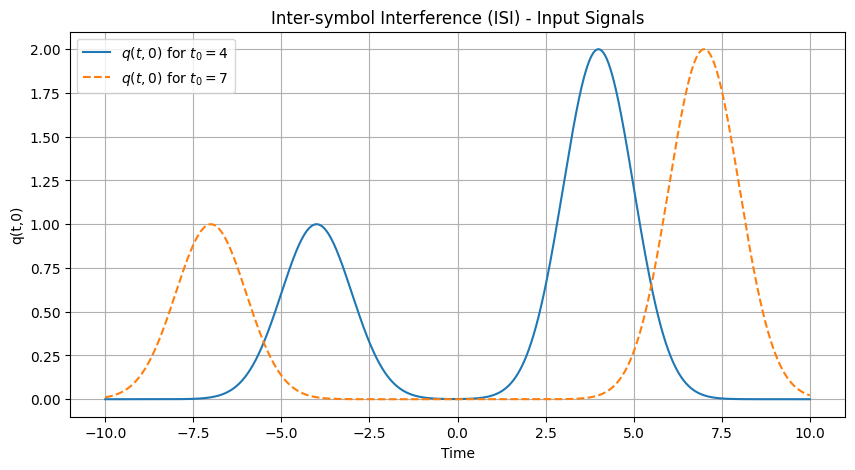

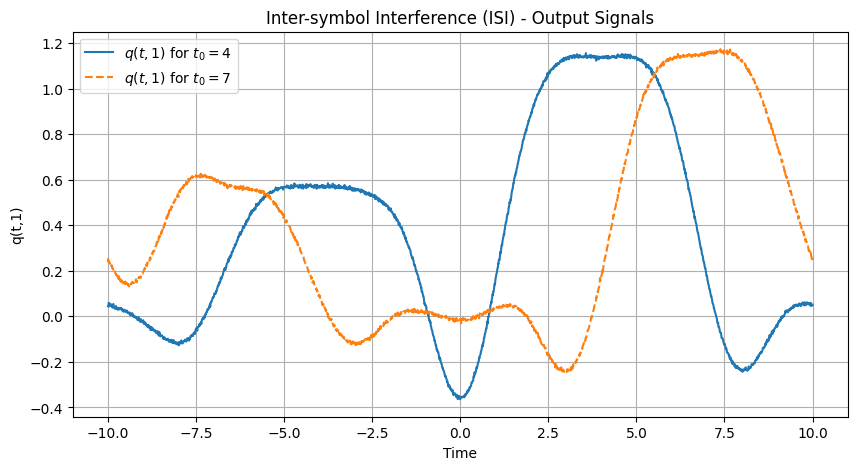

In [32]:
def q_t(t, t0):
  # Given parameters
  A1 = 1
  A2 = 2
  D = 1
  return A1 * np.exp(-((t + t0)**2) / (2 * D**2)) + A2 * np.exp(-((t - t0)**2) / (2 * D**2))

fs = 100  # Sampling frequency
t = np.linspace(-10, 10, fs*20)  # Time vector
q_t0_4 = q_t(t, 4)
q_t0_7 = q_t(t, 7)

# Pass signals through the channel
q_t0_4_noisy, q_t0_4_freq = channel(q_t0_4, 1, sigma2, 1, fs, 0)
q_t0_7_noisy, q_t0_7_freq = channel(q_t0_7, 1, sigma2, 1, fs, 0)

# Plot input signals
plt.figure(figsize=(10, 5))
plt.plot(t, q_t0_4, label=r'$q(t,0)$ for $t_0 = 4$', linestyle='solid')
plt.plot(t, q_t0_7, label=r'$q(t,0)$ for $t_0 = 7$', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('q(t,0)')
plt.title('Inter-symbol Interference (ISI) - Input Signals')
plt.legend()
plt.grid()
plt.show()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, np.real(q_t0_4_noisy), label=r'$q(t,1)$ for $t_0 = 4$', linestyle='solid')
plt.plot(t, np.real(q_t0_7_noisy), label=r'$q(t,1)$ for $t_0 = 7$', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('q(t,1)')
plt.title('Inter-symbol Interference (ISI) - Output Signals')
plt.legend()
plt.grid()
plt.show()

# **Implementation**

## **Optical Fiber Channel in Absense of Non-linearity**

In [33]:
channel_mode = 0 # Fiber channel with(=1)/without(=0) nonlinearity

### **Transmitter**

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


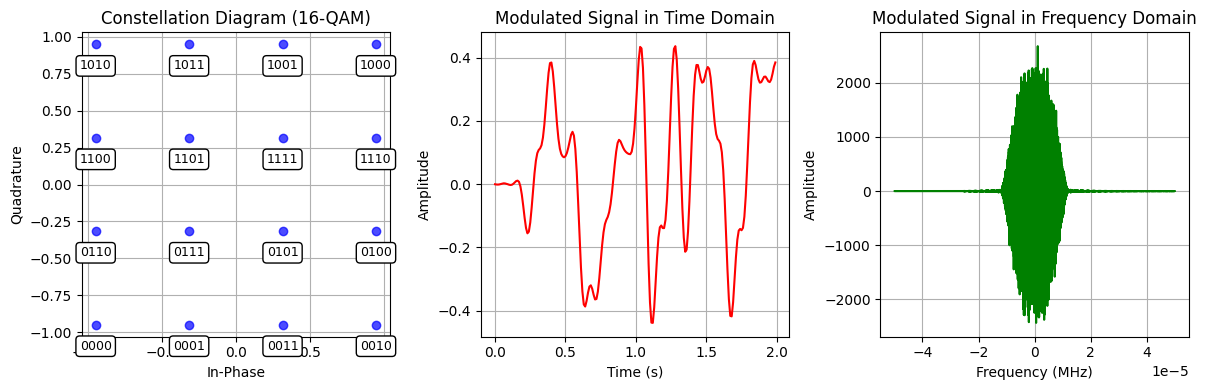

  - Symbol Rate (Rs): 1.25e+01 symbols/sec
  - Bit Rate (Rb): 5.00e+01 bits/sec
  - Bandwidth (BW): 1.80e+02 Hz


In [34]:
tx_smpl, sym_idx, b_tx, b_gray, BW, p, cons = transmitter(pkt_size, k, M, flg_gray_encode, modulation, pulse_name, signal_power,
                fs, smpl_per_symbl, span_in_symbl, beta, plot_mode = 1)

### **Channel Propagation and Equalization**

In [35]:
# Step 5: Propagation in the channel
xzt, xzf = channel(tx_smpl, L/L, sigma2, 1, fs, channel_mode)

# Step 6: Channel equalization
xzte, xzfe = linear_equalization(xzt, L/L, fs, channel_mode)

### **Receiver**

In [36]:
# Step 7: Demodulation and detection
det_sym_idx, rx_sym = pulse_demodulation(xzte, modulation, M, fs, smpl_per_symbl, pulse_name, rx_mode, pkt_size, signal_power, beta, span_in_symbl)

# Step 8: BER & SER
ber, ser = ber_ser(det_sym_idx, b_tx, sym_idx, b_gray)

print(f"Bit Error Rate (BER): {ber:.4f}")
print(f"Symbol Error Rate (SER): {ser:.4f}")

Bit Error Rate (BER): 0.0000
Symbol Error Rate (SER): 0.0000


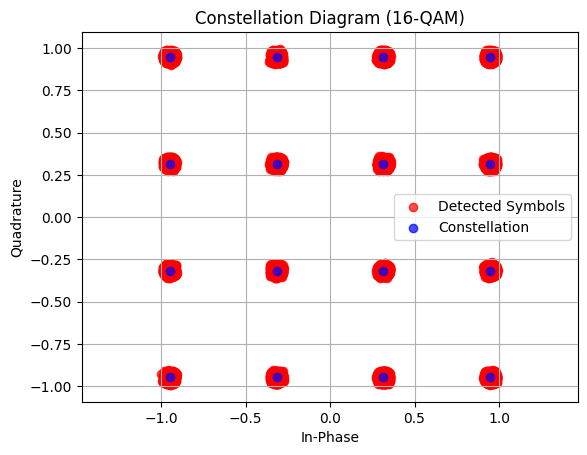

In [37]:
cons_plot(cons, M, modulation, rx_sym)

### **BER Performance vs. SNR**

In [38]:
ser = []
ber = []

for snr in snr_db:
  snr_lin = 10 ** (snr / 10)
  total_noise_power = sigma2
  signal_power = snr_lin * total_noise_power
  tx_smpl, sym_idx, b_tx, b_gray, BW, p, cons = transmitter(pkt_size, k, M, flg_gray_encode, modulation, pulse_name, signal_power,
                fs, smpl_per_symbl, span_in_symbl, beta, plot_mode = 0)
  xzt, xzf = channel(tx_smpl, L/L, sigma2, 1, fs, channel_mode)
  xzte, xzfe = linear_equalization(xzt, L/L, fs, channel_mode)
  det_sym_idx, rx_sym = pulse_demodulation(xzte, modulation, M, fs, smpl_per_symbl, pulse_name, rx_mode, pkt_size, signal_power, beta, span_in_symbl)
  ber_temp, ser_temp = ber_ser(det_sym_idx, b_tx, sym_idx, b_gray)
  ser.append(ser_temp)
  ber.append(ber_temp)

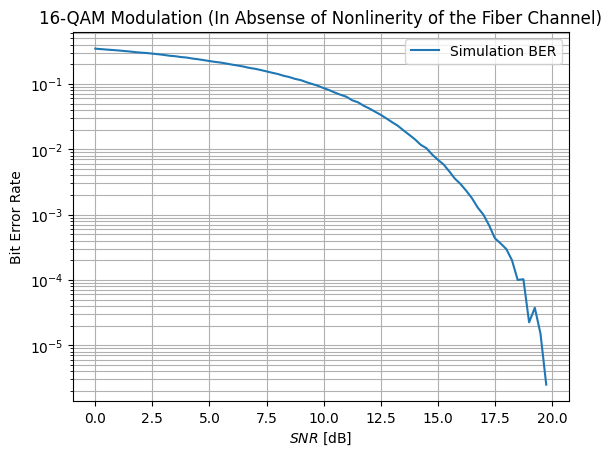

<Figure size 640x480 with 0 Axes>

In [39]:
ber_plot(snr_db, ber, M, modulation, channel_mode)

## **Optical Fiber Channel with Non-linearity**

In [40]:
channel_mode = 1 # Fiber channel with(=1)/without(=0) nonlinearity
snr = 35 # in dB
data_samples = 10000
block_size = 4
b, s, y = dataset_generation(snr, data_samples, block_size, k, M, flg_gray_encode, modulation, pulse_name,
                       fs, smpl_per_symbl, span_in_symbl, beta, sigma2, channel_mode,
                       signal_power = 1, plot_mode = 0, z = 1, B = 1)
np.save("received_signal.npy", y)
np.save("transmitted_sym.npy", s)
np.save("transmitted_bits.npy", b)

In [41]:
y = np.load("received_signal.npy")
s = np.load("transmitted_sym.npy")
b = np.load("transmitted_bits.npy")

# Real and imaginary part separation
y_real = np.real(y)
y_imag = np.imag(y)
y = np.hstack((y_real, y_imag))

X_train, X_test, y_train, y_test = train_test_split(y, b, test_size = 0.2, random_state=42)

# Input Preprocessing
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
# Output Preprocessing
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

In [42]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [43]:
# Determine the length of one channel (real/imag part)
input_dim = X_train.shape[1]
out_dim = y_train.shape[1]
input_length = input_dim // 2

# Instantiate the model
model = CNN_FC_Equalizer(input_length=input_length, out_dim=out_dim, kernel_size=5, hidden_dim=128)

# Compute estimated multiplications per decoded bit
mults_per_bit = compute_complexity(input_length=input_length, kernel_size=5, hidden_dim=128, out_dim=out_dim)
print(f"Estimated multiplications per decoded bit: {mults_per_bit:.2f}")

# Train the model
trained_model = train_equalizer(model, train_loader, test_loader, epochs=50, learning_rate=1e-3, device='cpu')

# Final evaluation on test set
trained_model.eval()
with torch.no_grad():
  outputs = trained_model(X_test)
  pred_bits = (outputs >= 0.5).float()
  ber_final = compute_ber(pred_bits, y_test)
  mi_final = mutual_information(ber_final)
print(f"Final Test BER: {ber_final:.4f}, Mutual Information: {mi_final:.4f}")

Estimated multiplications per decoded bit: 1325.00
Epoch 1/50: Train Loss = 0.6072, Test Loss = 0.5662, BER = 0.3728, MI = 0.0472
Epoch 2/50: Train Loss = 0.5550, Test Loss = 0.5504, BER = 0.3801, MI = 0.0419
Epoch 3/50: Train Loss = 0.5431, Test Loss = 0.5451, BER = 0.3716, MI = 0.0481
Epoch 4/50: Train Loss = 0.5366, Test Loss = 0.5401, BER = 0.3760, MI = 0.0448
Epoch 5/50: Train Loss = 0.5308, Test Loss = 0.5363, BER = 0.3568, MI = 0.0600
Epoch 6/50: Train Loss = 0.5254, Test Loss = 0.5336, BER = 0.3541, MI = 0.0623
Epoch 7/50: Train Loss = 0.5202, Test Loss = 0.5300, BER = 0.3498, MI = 0.0662
Epoch 8/50: Train Loss = 0.5140, Test Loss = 0.5234, BER = 0.3299, MI = 0.0852
Epoch 9/50: Train Loss = 0.5067, Test Loss = 0.5193, BER = 0.3200, MI = 0.0956
Epoch 10/50: Train Loss = 0.4986, Test Loss = 0.5111, BER = 0.3096, MI = 0.1073
Epoch 11/50: Train Loss = 0.4889, Test Loss = 0.5013, BER = 0.2975, MI = 0.1218
Epoch 12/50: Train Loss = 0.4791, Test Loss = 0.4922, BER = 0.2845, MI = 0.138